# py_regularization.ipynb

## Lecture 6 of CMU16-745 (2025)

Use JAX for automatic differentiation

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from jax.numpy.linalg import norm, solve, eig
import jax
import jax.numpy as jnp

In [2]:
Q = np.diag([0.5,1])
Q
# objective function
def f(x):
    x1 = jnp.array(x) - jnp.array([[1],[0]])
    return 0.5*(x1.T@Q@x1)[0,0]

# gradient 
def df(x):
    x1 = np.array(x) - np.array([[1],[0]])
    return Q@x1

# hessian 
def d2f(x):
    return Q


In [3]:
# constraint and gradient
def c(x):
    return x[0]**2 + 2*x[0] - x[1]

def dc(x):
    return [2*x[0]+2, -1]  

# write a wrapper function to handle JAX forward diff function
def dc_wrapper(x):
    global lambda_global
    return jnp.asarray(dc(x)).T*lambda_global


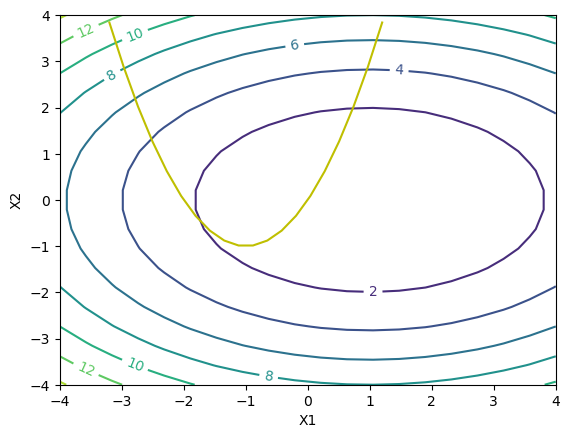

In [4]:
def plot_landscape():
    Nsamp = 20
    x = np.linspace(-4,4,Nsamp)
    y = np.linspace(-4,4,Nsamp)
    X, Y = np.meshgrid(x,y)
    Z = np.zeros((Nsamp,Nsamp))
    for j in range(Nsamp):
        for k in range(Nsamp):
            Z[j,k] = f([[X[j,k]], [Y[j,k]]])
    fig, ax = plt.subplots()
    CS = ax.contour(X,Y,Z)
    ax.clabel(CS, fontsize = 10)

    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

    xc = np.linspace(-3.2,1.2, Nsamp)
    yc = xc**2+2.0*xc
    ax.plot(xc,yc,'y-')

    return ax

ax = plot_landscape()   

In [5]:
def newton_step(x0,lambda0):
    global lambda_global
    lambda_global = lambda0
    H = d2f(x0) + jnp.asarray(jax.jacfwd(dc_wrapper)(x0))
    C = jnp.expand_dims(jnp.asarray(dc(x0)), axis=0)
    A = jnp.vstack((jnp.hstack((H,C.T)),jnp.hstack((C,jnp.zeros((1,1))))))
    x0a = jnp.expand_dims(x0,axis=1)
    B = jnp.vstack((-df(x0a)-C.T*lambda0, -jnp.asarray(c(x0a))))
    dz = jnp.linalg.solve(A,B)
    dx = dz[0:2]
    dlambda = dz[2]
    return x0a+dx, lambda0+dlambda
    

In [6]:
def plot_steps(xguess,i):
    ax = plot_landscape()
    ax.scatter(xguess[0,:], xguess[1,:],marker='x',color='g') 
    ax.scatter(xguess[0,-1], xguess[1,-1],marker='x',color='r')
    for ix in range(xguess.shape[1]-1):
        x1_old = xguess[0,ix]
        x1_new = xguess[0,ix+1]
        x2_old = xguess[1,ix]
        x2_new = xguess[1,ix+1]
        if jnp.linalg.norm(xguess[:,ix] - xguess[:,ix+1]).item() > 0.1: # plot arrow if distance large enough
            ax.arrow(x1_old,x2_old,(x1_new-x1_old)/2,(x2_new-x2_old)/2,head_width=0.1,color='m')
    ax.plot(xguess[0,:], xguess[1,:],'m')   
    ax.set_title("Iteration : " + str(i))

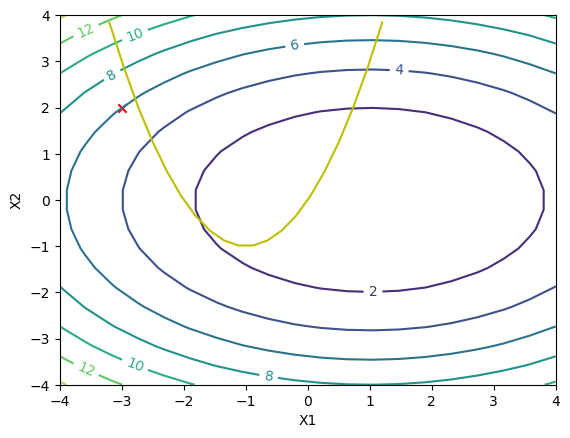

In [7]:
xguess = jnp.array([[-3.0],[2.0]])
lambdaguess = [0.0]
i=0
ax = plot_landscape()
ax.scatter(xguess[0], xguess[1],marker='x',color='r')

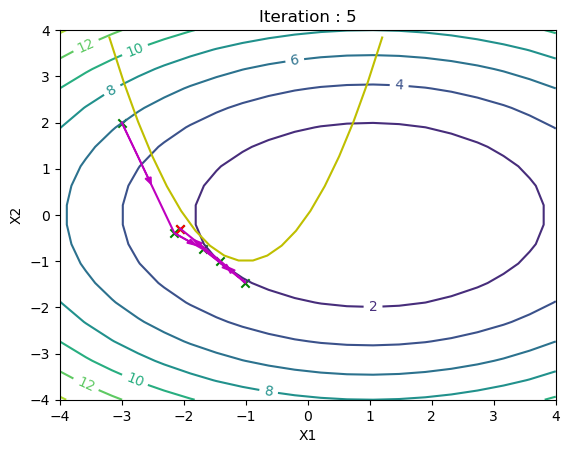

In [12]:
xnew, lambdanew = newton_step(xguess[:,-1],lambdaguess[-1])
xguess = jnp.hstack((xguess, xnew))
lambdaguess.append(lambdanew)
i+=1
plot_steps(xguess,i)

In [13]:
H = d2f(xguess[:,-1]) + jnp.asarray(jax.jacfwd(dc_wrapper)(xguess[:,-1]))
C = jnp.expand_dims(jnp.asarray(dc(xguess[:,-1])), axis=0)
A = jnp.vstack((jnp.hstack((H,C.T)),jnp.hstack((C,jnp.zeros((1,1))))))
evalA, evecA = eig(A)
evalA

Array([-3.0770426 +0.j,  0.45833835+0.j,  2.127892  +0.j], dtype=complex64)

In [64]:
def regularized_newton_step(x0,lambda0):
    global lambda_global
    lambda_global = lambda0
    lambdalen = len(lambda0)
    xlen = len(x0)
    H = d2f(x0) + jnp.asarray(jax.jacfwd(dc_wrapper)(x0))
    C = jnp.expand_dims(jnp.asarray(dc(x0)), axis=0)
    A = jnp.vstack((jnp.hstack((H,C.T)),jnp.hstack((C,jnp.zeros((1,1))))))
    evalA, evecA = eig(A)
    Rx = beta*np.ones((xlen))
    Rl = -beta*np.ones((lambdalen))
    R = np.diag(np.hstack((Rx,Rl)))    
    while not (sum(evalA>0)==xlen and sum(evalA<0)==lambdalen):
        A += R
        evalA, evecA = eig(A)
    x0a = jnp.expand_dims(x0,axis=1)
    B = jnp.vstack((-df(x0a)-C.T*lambda0, -jnp.asarray(c(x0a))))
    dz = solve(A,B)
    dx = dz[0:2]
    dlambda = dz[2]
    return x0a+dx, lambda0+dlambda
    

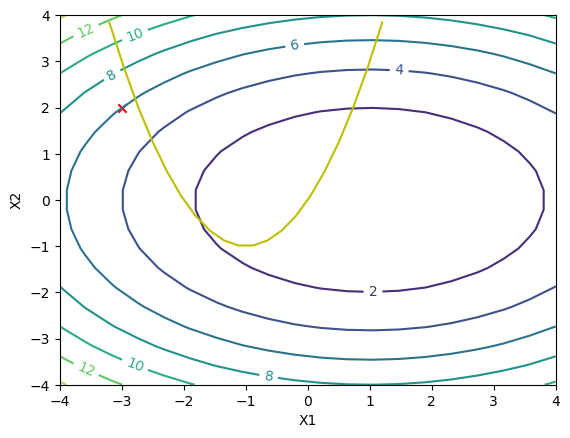

In [66]:
xguess = jnp.array([[-3.0],[2.0]])
lambdaguess = jnp.array([[0.0]])
i = 0
ax = plot_landscape()
ax.scatter(xguess[0], xguess[1],marker='x',color='r')

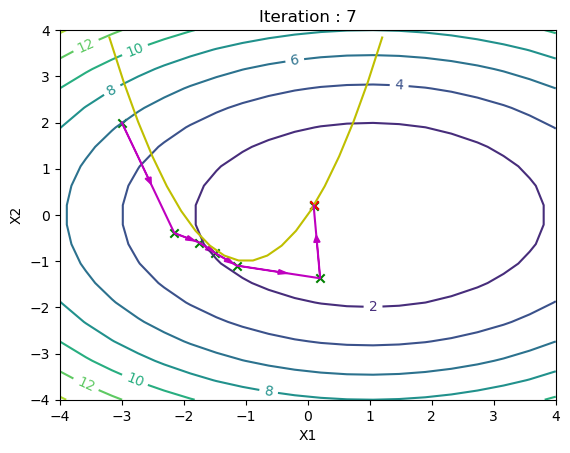

In [73]:
xnew, lambdanew = regularized_newton_step(xguess[:,-1],lambdaguess[-1])
xguess = jnp.hstack((xguess, xnew))
jnp.append(lambdaguess, lambdanew)
#lambdaguess.append(lambdanew)
i+=1
plot_steps(xguess,i)